In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input , Dense, Lambda, Normalization, Concatenate
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, schedules
from tensorflow_addons.optimizers import AdamW, extend_with_decoupled_weight_decay

from tensorflow.keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard, \
                                        EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

import numpy as np
import random
import os

import gc

from tqdm import tqdm 

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
import resource
from tensorflow.compat.v1 import set_random_seed

In [4]:
class ModelCheckpoint(Callback):
    def __init__(self, model, path, pre_loss = np.inf):
        super().__init__()
        
        self.model = model
        self.path = path
        if not os.path.exists(path): os.makedirs(path)
        self.best_loss = pre_loss
        
    def on_epoch_end(self, epoch, logs=None):
        loss = logs['val_loss']
        if loss < self.best_loss:
            print('\nSaving model to {}'.format(self.path.format(epoch=epoch, loss=loss)))
            print(', Validation loss decreased from {} to {}.\n'.format(self.best_loss, loss))
            self.model.save_weights(self.path.format(epoch=epoch, loss=loss), overwrite=True)
            self.best_loss = loss

In [5]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        print('Memory usage: ', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
        
    def on_batch_end(self, batch, logs=None):
        if int(K.get_value(self.model.optimizer.iterations))%50 == 0:
            gc.collect()

In [6]:
class BatchCallback(Callback):
    def __init__(self, callbacks_tensorboard, logdir):
        self.tb_callback = callbacks_tensorboard
        self.logdir = logdir
        self.train_writer = tf.summary.create_file_writer(os.path.join(self.logdir,"training"))
        self.val_writer = tf.summary.create_file_writer(os.path.join(self.logdir,"validation"))
        
        self.loss_tag = 'Epoch Summary/'
    
    def on_train_begin(self, logs={}):
        global_step = int(K.get_value(self.model.optimizer.iterations))
        print('[INFO][BatchCallback] global step:{}'.format(global_step))
        
    def on_train_batch_end(self, batch, logs={}):
        logs.update({'global_step': K.get_value(self.model.optimizer.iterations)})
        logs.update({'loss': logs['loss']})
        logs.update({'maskloss': logs['maskloss']})
        logs.update({'spectralloss': logs['spectralloss']})

        self._write_log(logs)
        
    def on_epoch_end(self, epoch, logs={}):
        train_writer = self.train_writer
        with train_writer.as_default():
            for key, val in logs.items():
                if key in ['loss']: tf.summary.scalar('loss', val, step=epoch)
        train_writer.flush()
        
        val_writer = self.val_writer
        with val_writer.as_default():
            for key, val in logs.items():
                if key in ['loss','val_loss']: tf.summary.scalar('loss', val, step=epoch)
        val_writer.flush()
        
    def _write_log(self, logs):
        writer = self.train_writer
        with writer.as_default():
            for key, val in logs.items():
                if key in ['maskloss', 'dfalphaloss', 'spectralloss']:
                    tag = 'Train(Metric)/' + key
                    tf.summary.scalar(tag, val, step=logs['global_step'])
                if key in ['loss']:
                    tag = 'Train(Total)/' + key.upper()
                    tf.summary.scalar(tag, val, step=logs['global_step'])
                
        writer.flush()

In [7]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0,
                             steps_per_epoch=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
#     learning_rate = learning_rate_base * 0.95 ** ((global_step - warmup_steps - hold_base_rate_steps) / (steps_per_epoch/25))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 mini_lr=0,
                 steps_per_epoch=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.steps_per_epoch = steps_per_epoch
        self.mini_lr = mini_lr
#         self.learning_rates = []

    def on_train_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
#         lr = K.get_value(self.model.optimizer.lr)
#         self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps,
                                      steps_per_epoch=self.steps_per_epoch)
        if lr < self.mini_lr: lr = self.mini_lr
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

In [8]:
class TrainCallback(Callback):
    def __init__(self, model):
        self.model = model
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch>=5:
            for layer in self.model.layers:
                layer.trainable=True

In [9]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# # Create a model.
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=100))
# model.add(Dense(10, activation='softmax'))
# model.compile(optimizer='rmsprop',
#             loss='categorical_crossentropy',
#             metrics=['accuracy'])

# # Number of training samples.
# sample_count = 100*32

# # Total epochs to train.
# epochs = 30

# # Number of warmup epochs.
# warmup_epoch = 2

# # Training batch size, set small value here for demonstration purpose.
# batch_size = 32

# # Base learning rate after warmup.
# learning_rate_base = 0.001

# total_steps = int(epochs * sample_count / batch_size)

# # Compute the number of warmup batches.
# warmup_steps = int(warmup_epoch * sample_count / batch_size)

# # Generate dummy data.
# data = np.random.random((sample_count, 100))
# labels = np.random.randint(10, size=(sample_count, 1))

# # Convert labels to categorical one-hot encoding.
# one_hot_labels = keras.utils.to_categorical(labels, num_classes=10)

# # Compute the number of warmup batches.
# warmup_batches = warmup_epoch * sample_count / batch_size

# # Create the Learning rate scheduler.
# warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=1e-4,
#                                         total_steps=epochs*100,
#                                         warmup_steps=1*100,
#                                         warmup_learning_rate = 1e-4,
#                                         mini_lr=1e-6,
#                                         steps_per_epoch=100,
#                                         global_step_init=0*100,
#                                         verbose = 1)

# # Train the model, iterating on the data in batches of 32 samples
# model.fit(data, one_hot_labels, epochs=epochs, batch_size=batch_size,
#         verbose=0, callbacks=[warm_up_lr])

# import matplotlib.pyplot as plt
# plt.plot(warm_up_lr.learning_rates)
# plt.xlabel('Step', fontsize=20)
# plt.ylabel('lr', fontsize=20)
# plt.axis([0, total_steps, 0, learning_rate_base*1.1])
# plt.xticks(np.arange(0, total_steps, 50))
# plt.grid()
# plt.title('Cosine decay with warmup', fontsize=20)
# plt.show()

In [27]:
# lr = []
# for i in range(30):
#     lr.append(cosine_decay_with_warmup(global_step=i,
#                               learning_rate_base=1e-3,
#                               total_steps=30*1,
#                               warmup_learning_rate=1e-4,
#                               warmup_steps=3*1,
#                               hold_base_rate_steps=0,
#                               steps_per_epoch=1))
# for i in range(3):
#     for j in range(10):
#         print('%.7f'%lr[i*10+j], end=' ')
#     print()
# lr[-1]

0.0001000 0.0004000 0.0007000 0.0010000 0.0009966 0.0009865 0.0009698 0.0009468 0.0009177 0.0008830 
0.0008431 0.0007986 0.0007500 0.0006980 0.0006434 0.0005868 0.0005291 0.0004709 0.0004132 0.0003566 
0.0003020 0.0002500 0.0002014 0.0001569 0.0001170 0.0000823 0.0000532 0.0000302 0.0000135 0.0000034 


array(3.38082113e-06)

[1.00e-04 4.00e-04 7.00e-04 1.00e-03 9.97e-04 9.87e-04 9.70e-04 9.47e-04
 9.18e-04 8.83e-04 8.43e-04 7.99e-04 7.50e-04 6.98e-04 6.43e-04 5.87e-04
 5.29e-04 4.71e-04 4.13e-04 3.57e-04 3.02e-04 2.50e-04 2.01e-04 1.57e-04
 1.17e-04 8.20e-05 5.30e-05 3.00e-05 1.30e-05 3.00e-06]


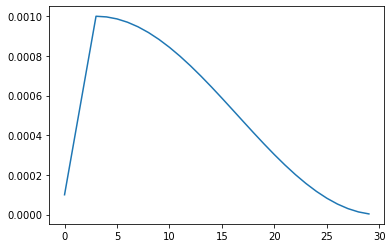

In [19]:
# print(np.round(lr,6))
# import matplotlib.pyplot as plt
# plt.plot(lr)